# Fitting the high-k linear power spectrum
We would like to see if we can compress the linear power spectrum information in a handful of parameters.
In this notebook we focus on the shape at the central redshift.

In [1]:
%matplotlib inline
import numpy as np
import os
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import camb
from camb import model, initialpower

### Run CAMB for a given cosmology

In [2]:
## output redshifts
zs=[4,3,2]
## parameters matching params_ref.ini
omnuh2=0.00064
mnu=93.14*omnuh2
omch2=0.112
ombh2=0.0226
omk=0.0
hubble=70
YHe=0.24
TCMB=2.7255
ns=0.96
As=2.1e-09

In [3]:
## Generate cosmology
pars = camb.CAMBparams()
pars.set_cosmology(H0=hubble, ombh2=ombh2, omch2=omch2, omk=omk,num_massive_neutrinos=1, 
                   neutrino_hierarchy='degenerate',mnu=mnu,YHe=YHe,TCMB=TCMB)
pars.InitPower.set_params(As=As, ns=ns)
pars.set_matter_power(redshifts=zs, kmax=30.0);

In [4]:
results = camb.get_results(pars)
# fluid=8 specifies that went the power spectrum for CDM+baryons
fluid=8
# need to specify a higher number of k points to have proper description at k ~ 1 h/Mpc
kh, zs, Ph = results.get_matter_power_spectrum(have_power_spectra=True,var1=fluid,var2=fluid,npoints=1000,maxkh=20)

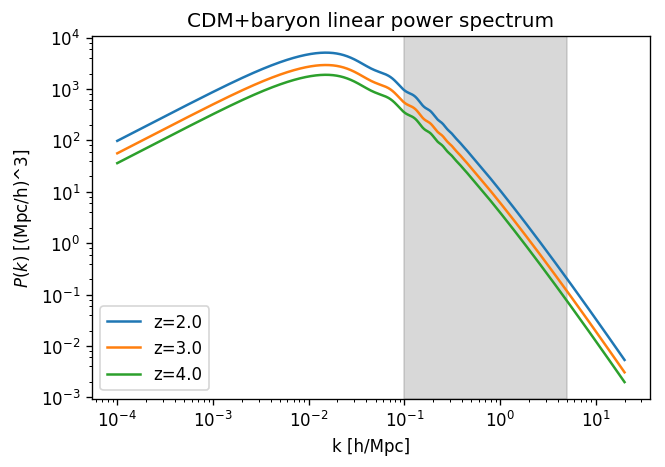

In [5]:
Nz=len(zs)
plt.figure()
for iz in range(Nz): 
    z=zs[iz]
    plt.loglog(kh,Ph[iz],label='z='+str(z))
plt.title(r"CDM+baryon linear power spectrum")
plt.xlabel("k [h/Mpc]")
plt.ylabel(r"$P(k)$ [(Mpc/h)^3]")
plt.legend()
plt.axvspan(0.1,5.0,alpha=0.3, color='gray')

## Fit a power-law (with running) to the high-k power spectrum

In [6]:
# use a single redshift
iz=1
# use a certain k range to fit
kh_fit_min=0.8
kh_fit_max=1.0/0.8
kh_fit= (kh > kh_fit_min) & (kh < kh_fit_max)
poly_deg1=np.polyfit(np.log(kh[kh_fit]), np.log(Ph[iz][kh_fit]), deg=1)
Ph_deg1 = np.poly1d(poly_deg1)
poly_deg2=np.polyfit(np.log(kh[kh_fit]), np.log(Ph[iz][kh_fit]), deg=2)
Ph_deg2 = np.poly1d(poly_deg2)

(0.1, 10000.0)

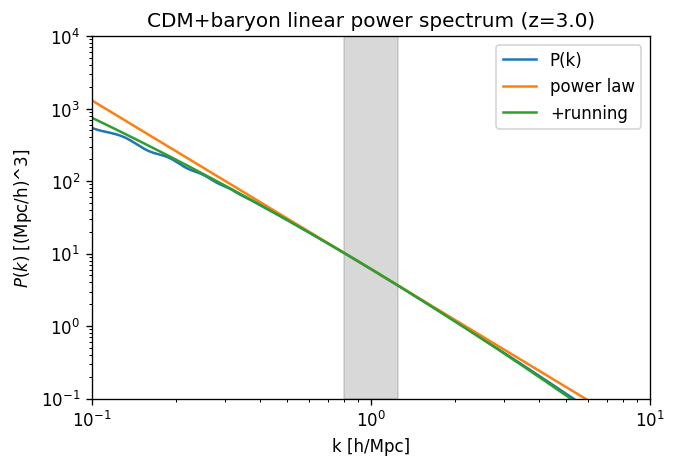

In [7]:
plt.figure()
plt.loglog(kh,Ph[iz],label='P(k)')
plt.loglog(kh,np.exp(Ph_deg1(np.log(kh))),label='power law')
plt.loglog(kh,np.exp(Ph_deg2(np.log(kh))),label='+running')
plt.title(r"CDM+baryon linear power spectrum (z="+str(zs[iz])+")")
plt.xlabel("k [h/Mpc]")
plt.ylabel(r"$P(k)$ [(Mpc/h)^3]")
plt.legend()
plt.axvspan(kh_fit_min,kh_fit_max,alpha=0.3, color='gray')
plt.xlim(0.1,10.0)
plt.ylim(1e-1,1e4)

(0.5, 1.3)

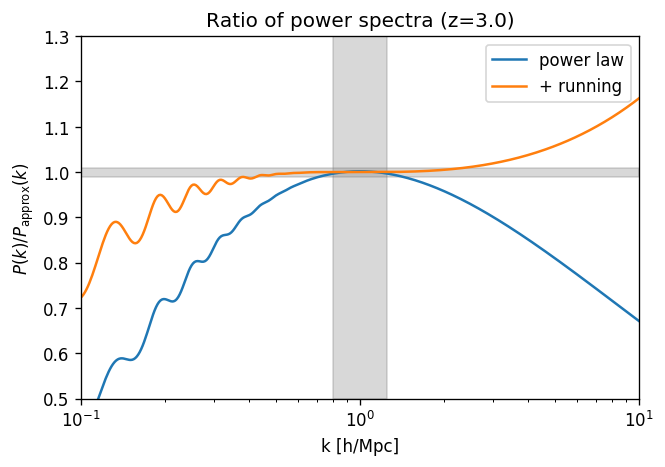

In [8]:
plt.figure()
plt.semilogx(kh,Ph[iz]/np.exp(Ph_deg1(np.log(kh))),label='power law')
plt.semilogx(kh,Ph[iz]/np.exp(Ph_deg2(np.log(kh))),label='+ running')
plt.title(r"Ratio of power spectra (z="+str(zs[iz])+")")
plt.xlabel("k [h/Mpc]")
plt.ylabel(r"$P(k)/P_{\rm approx}(k)$")
plt.legend()
plt.axvspan(kh_fit_min,kh_fit_max,alpha=0.3, color='gray')
plt.axhspan(0.99,1.01,alpha=0.3, color='gray')
plt.xlim(0.1,10.0)
plt.ylim(0.5,1.3)

## Fit ratios with respect to fiducial cosmology

In [9]:
## Generate default cosmology
pars_fid = camb.CAMBparams()
pars_fid.set_cosmology(H0=67)
pars_fid.set_matter_power(redshifts=zs, kmax=30.0)
results_fid = camb.get_results(pars_fid)
# need to specify a higher number of k points to have proper description at k ~ 1 h/Mpc
kh_fid, _ , Ph_fid = results_fid.get_matter_power_spectrum(have_power_spectra=True,var1=fluid,var2=fluid,npoints=1000,maxkh=20)

Note: redshifts have been re-sorted (earliest first)


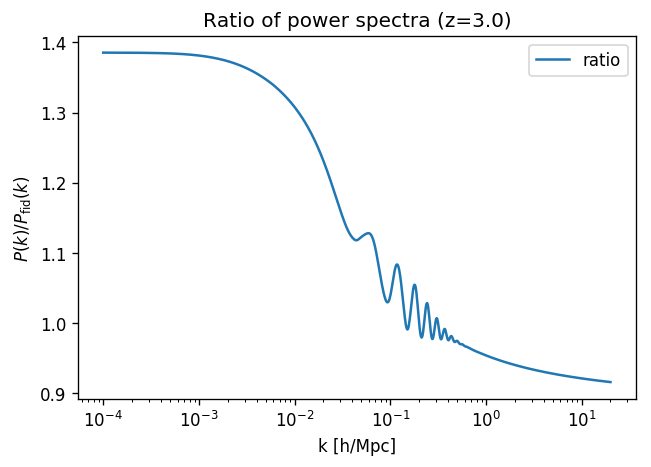

In [10]:
plt.figure()
plt.semilogx(kh,Ph[iz]/Ph_fid[iz],label='ratio')
plt.title(r"Ratio of power spectra (z="+str(zs[iz])+")")
plt.xlabel("k [h/Mpc]")
plt.ylabel(r"$P(k)/P_{\rm fid}(k)$")
plt.legend()

### Compute ratio in units of Mpc, not Mpc/h

In [11]:
h=pars.H0/100.0
h_fid=pars_fid.H0/100.0

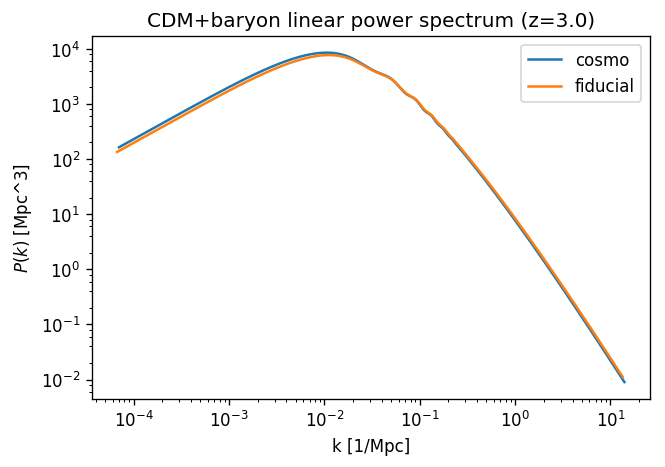

In [12]:
plt.figure()
plt.loglog(kh*h,Ph[iz]/h**3,label='cosmo')
plt.loglog(kh_fid*h_fid,Ph_fid[iz]/h_fid**3,label='fiducial')
plt.title(r"CDM+baryon linear power spectrum (z="+str(zs[iz])+")")
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"$P(k)$ [Mpc^3]")
plt.legend()

In [13]:
k=np.logspace(-4,1,1000)
Pk=np.interp(k/h,kh,Ph[iz]/h**3)
Pk_fid=np.interp(k/h_fid,kh_fid,Ph_fid[iz]/h_fid**3)

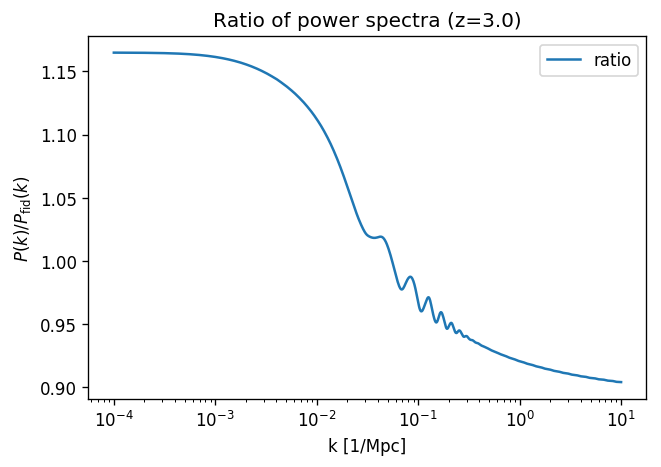

In [14]:
plt.figure()
plt.semilogx(k,Pk/Pk_fid,label='ratio')
plt.title(r"Ratio of power spectra (z="+str(zs[iz])+")")
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"$P(k)/P_{\rm fid}(k)$")
plt.legend()
#plt.xlim(0.1,10.0)
#plt.ylim(0.9,1.0)

### Fit ratio

In [15]:
# use a certain k range to fit
k_fit_min=0.8
k_fit_max=1.0/0.8
k_fit= (k > k_fit_min) & (k < k_fit_max)
poly_deg1=np.polyfit(np.log(k[k_fit]), np.log(Pk[k_fit]/Pk_fid[k_fit]), deg=1)
Pk_ratio_deg1 = np.poly1d(poly_deg1)
poly_deg2=np.polyfit(np.log(k[k_fit]), np.log(Pk[k_fit]/Pk_fid[k_fit]), deg=2)
Pk_ratio_deg2 = np.poly1d(poly_deg2)

(0.95, 1.05)

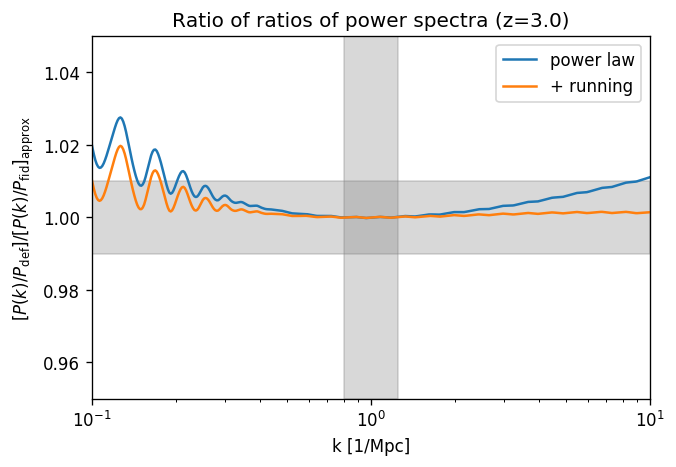

In [16]:
plt.figure()
plt.semilogx(k,Pk/Pk_fid/np.exp(Pk_ratio_deg1(np.log(k))),label='power law')
plt.semilogx(k,Pk/Pk_fid/np.exp(Pk_ratio_deg2(np.log(k))),label='+ running')
plt.title(r"Ratio of ratios of power spectra (z="+str(zs[iz])+")")
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"$[P(k)/P_{\rm def}] / [P(k)/P_{\rm fid}]_{\rm approx}$")
plt.axvspan(k_fit_min,k_fit_max,alpha=0.3, color='gray')
plt.axhspan(0.99,1.01,alpha=0.3, color='gray')
plt.legend()
plt.xlim(0.1,10.0)
plt.ylim(0.95,1.05)

### Now repeat using homemade function

In [17]:
import fit_pk

In [18]:
k_ratio = k[k_fit]
P_ratio = Pk[k_fit]/Pk_fid[k_fit]
# try two different polynomials
P_ratio_deg1=fit_pk.fit_polynomial(0.8,1.2,k_ratio,P_ratio,deg=1)
P_ratio_deg2=fit_pk.fit_polynomial(0.8,1.2,k_ratio,P_ratio,deg=2)

(0.95, 1.05)

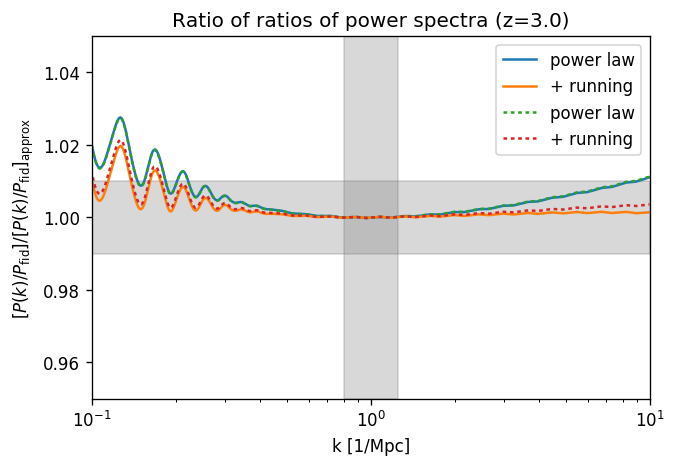

In [19]:
plt.figure()
plt.semilogx(k,Pk/Pk_fid/np.exp(Pk_ratio_deg1(np.log(k))),'-',label='power law')
plt.semilogx(k,Pk/Pk_fid/np.exp(Pk_ratio_deg2(np.log(k))),'-',label='+ running')
plt.semilogx(k,Pk/Pk_fid/np.exp(P_ratio_deg1(np.log(k))),':',label='power law')
plt.semilogx(k,Pk/Pk_fid/np.exp(P_ratio_deg2(np.log(k))),':',label='+ running')
plt.title(r"Ratio of ratios of power spectra (z="+str(zs[iz])+")")
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"$[P(k)/P_{\rm fid}] / [P(k)/P_{\rm fid}]_{\rm approx}$")
plt.axvspan(k_fit_min,k_fit_max,alpha=0.3, color='gray')
plt.axhspan(0.99,1.01,alpha=0.3, color='gray')
plt.legend()
plt.xlim(0.1,10.0)
plt.ylim(0.95,1.05)

### Compare fitting ratio or fitting each individually

In [20]:
k=np.logspace(-4,1,1000)
Pk=np.interp(k/h,kh,Ph[iz]/h**3)
Pk_fid=np.interp(k/h_fid,kh_fid,Ph_fid[iz]/h_fid**3)

In [21]:
# use a certain k range to fit
k_fit_min=0.8
k_fit_max=1.2
k_fit= (k > k_fit_min) & (k < k_fit_max)

In [22]:
# fit both power separately
poly_deg1=np.polyfit(np.log(k[k_fit]), np.log(Pk[k_fit]), deg=1)
Pk_deg1 = np.poly1d(poly_deg1)
poly_deg2=np.polyfit(np.log(k[k_fit]), np.log(Pk[k_fit]), deg=2)
Pk_deg2 = np.poly1d(poly_deg2)
poly_fid_deg1=np.polyfit(np.log(k[k_fit]), np.log(Pk_fid[k_fit]), deg=1)
Pk_fid_deg1 = np.poly1d(poly_fid_deg1)
poly_fid_deg2=np.polyfit(np.log(k[k_fit]), np.log(Pk_fid[k_fit]), deg=2)
Pk_fid_deg2 = np.poly1d(poly_fid_deg2)

In [23]:
# fit ratio
poly_ratio_deg1=np.polyfit(np.log(k[k_fit]), np.log(Pk[k_fit]/Pk_fid[k_fit]), deg=1)
Pk_ratio_deg1 = np.poly1d(poly_ratio_deg1)
poly_ratio_deg2=np.polyfit(np.log(k[k_fit]), np.log(Pk[k_fit]/Pk_fid[k_fit]), deg=2)
Pk_ratio_deg2 = np.poly1d(poly_ratio_deg2)

(0.95, 1.05)

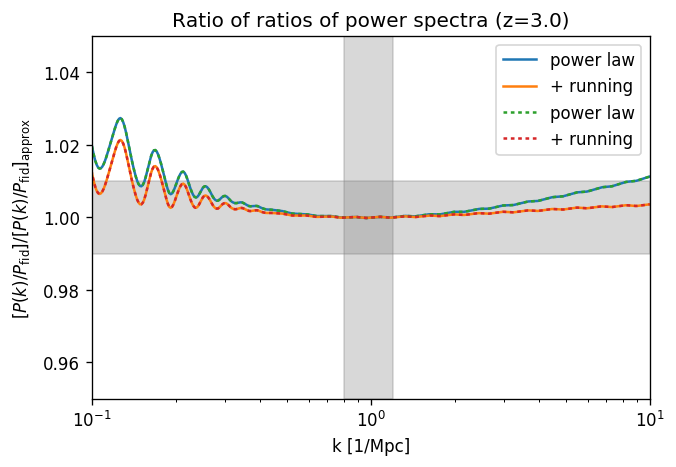

In [24]:
plt.figure()
plt.semilogx(k,Pk/Pk_fid/np.exp(Pk_ratio_deg1(np.log(k))),'-',label='power law')
plt.semilogx(k,Pk/Pk_fid/np.exp(Pk_ratio_deg2(np.log(k))),'-',label='+ running')
plt.semilogx(k,Pk/Pk_fid/np.exp(Pk_deg1(np.log(k)))*np.exp(Pk_fid_deg1(np.log(k))),':',label='power law')
plt.semilogx(k,Pk/Pk_fid/np.exp(Pk_deg2(np.log(k)))*np.exp(Pk_fid_deg2(np.log(k))),':',label='+ running')
plt.title(r"Ratio of ratios of power spectra (z="+str(zs[iz])+")")
plt.xlabel("k [1/Mpc]")
plt.ylabel(r"$[P(k)/P_{\rm fid}] / [P(k)/P_{\rm fid}]_{\rm approx}$")
plt.axvspan(k_fit_min,k_fit_max,alpha=0.3, color='gray')
plt.axhspan(0.99,1.01,alpha=0.3, color='gray')
plt.legend()
plt.xlim(0.1,10.0)
plt.ylim(0.95,1.05)

In [25]:
print('deg=1, fit for input cosmology',np.array(Pk_deg1))
print('deg=1, fit for fiducial cosmology',np.array(Pk_fid_deg1))
print('deg=1, fit for ratio',np.array(Pk_ratio_deg1))
print('deg=1, difference in fits',np.array(Pk_ratio_deg1)-np.array(Pk_deg1)+np.array(Pk_fid_deg1))

deg=1, fit for input cosmology [-2.39123518  2.04216489]
deg=1, fit for fiducial cosmology [-2.37847895  2.12470227]
deg=1, fit for ratio [-0.01275624 -0.08253738]
deg=1, difference in fits [  8.88178420e-16   8.88178420e-16]


In [26]:
print('deg=2, fit for input cosmology',np.array(Pk_deg2))
print('deg=2, fit for fiducial cosmology',np.array(Pk_fid_deg2))
print('deg=2, fit for ratio',np.array(Pk_ratio_deg2))
print('deg=2, difference in fits',np.array(Pk_ratio_deg2)-np.array(Pk_deg2)+np.array(Pk_fid_deg2))

deg=2, fit for input cosmology [-0.08901678 -2.39472314  2.04340658]
deg=2, fit for fiducial cosmology [-0.09043191 -2.38202235  2.12596369]
deg=2, fit for ratio [ 0.00141513 -0.01270079 -0.08255712]
deg=2, difference in fits [  2.88241653e-14  -1.33226763e-15   0.00000000e+00]
